## Import

In [322]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Data load

In [2]:
zip_path = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

In [3]:
file_path = os.path.dirname(zip_path)+"/spa-eng/spa.txt"

with open(file_path, "r") as f:
    spa_eng_sentences = f.read().splitlines()

spa_eng_sentences = list(set(spa_eng_sentences)) 
total_sentence_count = len(spa_eng_sentences)
print("Example:", total_sentence_count)

for sen in spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Example: 118964
>> Is this enough money?	¿Es esto suficiente dinero?
>> Please choose wisely.	Por favor, escoja sabiamente.
>> How annoying!	¡No hay quién lo aguante!
>> Are they busy?	¿Están ocupados?
>> I've corrected the mistake.	Corregí el error.


## Preprocessing

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
spa_eng_sentences = list(map(preprocess_sentence, spa_eng_sentences))

In [6]:
test_sentence_count = total_sentence_count // 200
print("Test Size: ", test_sentence_count)
print("\n")

train_spa_eng_sentences = spa_eng_sentences[:-test_sentence_count]
test_spa_eng_sentences = spa_eng_sentences[-test_sentence_count:]
print("Train Example:", len(train_spa_eng_sentences))
for sen in train_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)
print("\n")
print("Test Example:", len(test_spa_eng_sentences))
for sen in test_spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Test Size:  594


Train Example: 118370
>> is this enough money?	¿es esto suficiente dinero?
>> please choose wisely.	por favor, escoja sabiamente.
>> how annoying!	¡no hay quién lo aguante!
>> are they busy?	¿están ocupados?
>> i've corrected the mistake.	corregí el error.


Test Example: 594
>> how long are you going to stay here?	¿cuánto tiempo vas a quedarte aquí?
>> muammar kaddafi escaped unharmed.	muamar alqadaafi escapó ileso.
>> his family moved into a new house in the suburbs.	su familia se mudó a una casa nueva en las afueras de la ciudad.
>> tom thought only of mary.	tom solo pensó en mary.
>> i'm very busy so don't count on me.	estoy muy ocupada, así que no cuentes conmigo.


In [7]:
def split_spa_eng_sentences(spa_eng_sentences):
    spa_sentences = []
    eng_sentences = []
    for spa_eng_sentence in tqdm(spa_eng_sentences):
        eng_sentence, spa_sentence = spa_eng_sentence.split('\t')
        spa_sentences.append(spa_sentence)
        eng_sentences.append(eng_sentence)
    return eng_sentences, spa_sentences


In [8]:
train_eng_sentences, train_spa_sentences = split_spa_eng_sentences(train_spa_eng_sentences)
print(len(train_eng_sentences))
print(train_eng_sentences[0])
print('\n')
print(len(train_spa_sentences))
print(train_spa_sentences[0])

  0%|          | 0/118370 [00:00<?, ?it/s]

118370
is this enough money?


118370
¿es esto suficiente dinero?


In [9]:
test_eng_sentences, test_spa_sentences = split_spa_eng_sentences(test_spa_eng_sentences)
print(len(test_eng_sentences))
print(test_eng_sentences[0])
print('\n')
print(len(test_spa_sentences))
print(test_spa_sentences[0])

  0%|          | 0/594 [00:00<?, ?it/s]

594
how long are you going to stay here?


594
¿cuánto tiempo vas a quedarte aquí?


## Tokenization

In [10]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="spa-eng",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [11]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_eng_sentences + train_spa_sentences, VOCAB_SIZE, 'spa-eng')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././spa-eng_corpus.txt --model_prefix=spa-eng_spm --vocab_size=20000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././spa-eng_corpus.txt
  input_format: 
  model_prefix: spa-eng_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1

True

In [12]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus

In [13]:
eng_corpus = make_corpus(train_eng_sentences, tokenizer)
spa_corpus = make_corpus(train_spa_sentences, tokenizer)

  0%|          | 0/118370 [00:00<?, ?it/s]

  0%|          | 0/118370 [00:00<?, ?it/s]

In [14]:
print(train_eng_sentences[0])
print(eng_corpus[0])
print('\n')
print(train_spa_sentences[0])
print(spa_corpus[0])

is this enough money?
[1, 21, 41, 475, 203, 8, 2]


¿es esto suficiente dinero?
[1, 18, 184, 139, 582, 209, 8, 2]


In [15]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(spa_corpus, maxlen=MAX_LEN, padding='post')

In [16]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

## Modeling

#### Positional encoding

In [17]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

#### Masking

In [18]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

#### Multi-head attention

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

#### Position-wise feed forward network

In [20]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

#### Encoder layer

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### Decoder layer

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [26]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [27]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [30]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

# Training

In [31]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

## BLEU score

In [32]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [33]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


#### SmoothingFunction()으로 BLEU Score 보정하기

In [34]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


## 번역 성능 알아보기

In [35]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

슝=3


In [36]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

슝=3


In [37]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 0

eval_bleu_single(transformer, 
                 test_eng_sentences[test_idx], 
                 test_spa_sentences[test_idx], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  how long are you going to stay here?
Model Prediction:  ['¿cuánto', 'se', 'va', 'a', 'quedar', 'aquí?']
Real:  ['¿cuánto', 'tiempo', 'vas', 'a', 'quedarte', 'aquí?']
Score: 0.053728



0.05372849659117709

In [38]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

슝=3


In [39]:
eval_bleu(transformer, test_eng_sentences, test_spa_sentences, tokenizer, tokenizer, verbose=False)

  0%|          | 0/594 [00:00<?, ?it/s]

Num of Sample: 594
Total Score: 0.0911819539701506


## Beam search decoder

In [40]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

In [41]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


In [42]:
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [43]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

In [44]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

In [45]:
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

In [46]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 2

ids = \
beam_search_decoder(test_eng_sentences[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_spa_sentences[test_idx], ids, tokenizer)
print(bleu)

Reference: ['tome', 'este', 'medicamento', 'después', 'de', 'las', 'comidas.']
Candidate: ['toma', 'esta', 'medicina', 'después', 'de', 'las', 'comidas', 'después', 'de', 'esta', 'comida', 'después', 'de', 'las', 'comidas?']
BLEU: 0.06541868941754436
Reference: ['tome', 'este', 'medicamento', 'después', 'de', 'las', 'comidas.']
Candidate: ['toma', 'esta', 'medicina', 'después', 'de', 'las', 'comidas', 'después', 'de', 'comer', 'comida', 'después', 'de', 'las', 'comidas?']
BLEU: 0.06541868941754436
Reference: ['tome', 'este', 'medicamento', 'después', 'de', 'las', 'comidas.']
Candidate: ['toma', 'esta', 'medicina', 'después', 'de', 'las', 'comidas', 'después', 'de', 'esta', 'comidas', 'después', 'de', 'las', 'comidas?']
BLEU: 0.06541868941754436
Reference: ['tome', 'este', 'medicamento', 'después', 'de', 'las', 'comidas.']
Candidate: ['toma', 'esta', 'medicina', 'después', 'de', 'las', 'comidas', 'después', 'de', 'los', 'comida', 'después', 'de', 'las', 'comidas?']
BLEU: 0.0654186894175

## Augmentation

In [47]:
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-300')

[=================================================-] 98.0% 368.7/376.1MB downloaded


In [48]:
wv.most_similar("banana")

[('bananas', 0.6691170930862427),
 ('mango', 0.5804104208946228),
 ('pineapple', 0.5492372512817383),
 ('coconut', 0.5462778806686401),
 ('papaya', 0.541056752204895),
 ('fruit', 0.52181077003479),
 ('growers', 0.4877638816833496),
 ('nut', 0.48399588465690613),
 ('peanut', 0.48062023520469666),
 ('potato', 0.48061180114746094)]

In [49]:
sample_sentence = "you know ? all you need is attention ."
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += wv.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: you know ? all you need is attention .
To: you know ? all you need is attention , 


## Lexical Substitution

In [50]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [51]:
new_corpus = []

for old_src in tqdm(test_eng_sentences):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

  0%|          | 0/594 [00:00<?, ?it/s]

["how long are 'll going to stay here? ", 'how long are you going to stay here?', "'d was busy all day. ", 'i was busy all day.', 'take this medical after meals. ', 'take this medicine after meals.', 'there now a church across the street. ', 'there is a church across the street.', 'achille was born where paris in 1908. ', 'achille was born in paris in 1908.']


## Imports

In [303]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from gensim.models import Word2Vec
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [264]:
#!pip install --upgrade gensim==3.8.3

## Data load

In [265]:
path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data'

In [266]:
data = pd.read_csv(path +'/ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## EDA

In [267]:
len(data)

11823

In [268]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [269]:
data = data.iloc[:,:2]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [270]:
for i in range(10):
    print('Q :', data['Q'][i])
    print('A :', data['A'][i])    
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



In [271]:
data[data.duplicated(['Q'])]

,Q,A
196,고양이 키우고 싶어,가족들과 상의해보세요.
235,공시 준비 힘들어,잘 될 거예요.
1294,돈 벌고 싶어,많이 벌수록 좋아요.
1445,로또 번호 알려줘,알면 제가 하죠.
1481,마음이 울적해,거리를 걸어보세요.
...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.
11658,첫사랑 생각나,지금의 사랑에 충실하세요.
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.


In [272]:
data[data.duplicated(['A'])]

,Q,A
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.
...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.


문장의 최단 길이: 1
문장의 최장 길이: 57
문장의 평균 길이: 14


/tmp/ipykernel_233/3564982157.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


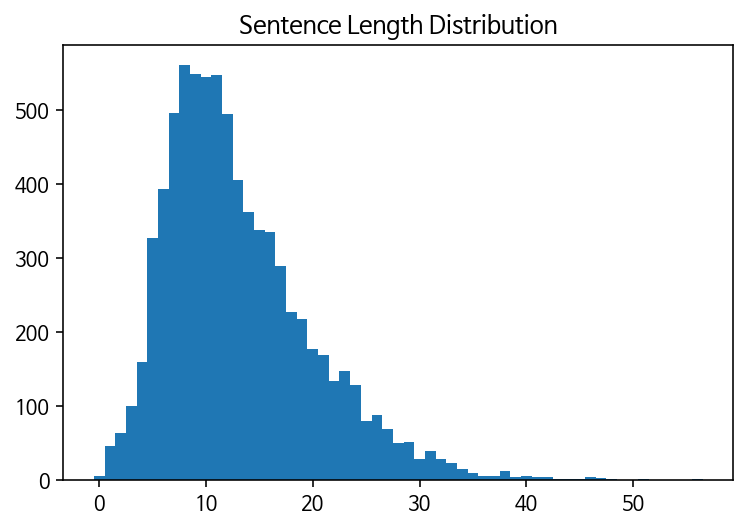

In [273]:
min_len = 999
max_len = 0
sum_len = 0

for sen in questions:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(questions))

train_length = np.zeros((max_len), dtype=np.int)

for sen in questions:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 76
문장의 평균 길이: 16


/tmp/ipykernel_233/3544393292.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


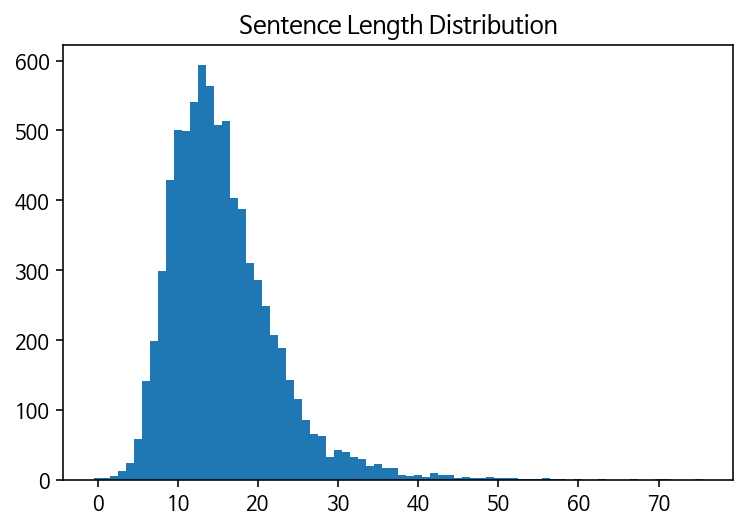

In [274]:
min_len = 999
max_len = 0
sum_len = 0

for sen in answers:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(answers))

train_length = np.zeros((max_len), dtype=np.int)

for sen in answers:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## Preprocessing and Tokeninzing

In [275]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [276]:
def build_corpus(row_file):
    que_corpus = []
    ans_corpus = []
    
    for i in range(0, len(row_file)):
        mecab = Mecab()
        
        que, ans = row_file.loc[i]
        
        que = preprocess_sentence(que)
        que = mecab.morphs(que)
        
        ans = preprocess_sentence(ans)
        ans = mecab.morphs(ans)
        
        if len(que) < 40 and len(ans) < 60: # 길이의 75퍼센타일 
            if que not in que_corpus:
                if ans not in ans_corpus: #소스와 타겟별 중복 검사
                    que_corpus.append(que)
                    ans_corpus.append(ans)
    
    return que_corpus, ans_corpus

In [277]:
que_corpus, ans_corpus = build_corpus(data)

In [278]:
que_corpus[:10]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다']]

In [279]:
ans_corpus[:10]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', '니까요', '.'],
 ['그', '사람', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '즐기', '세요', '.']]

## Augmentation

In [280]:
ko_bin_path = path + '/ko.bin'

In [281]:
word2vec = Word2Vec.load(ko_bin_path)

In [282]:
def lexical_sub(sentence, word2vec):
    

    res = []
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return sentence

    for tok in toks:
        if tok is _from: res.append(_to)
        else: res.append(tok)

    return res

In [283]:
temp = ['12', '시', '땡', '!']

In [284]:
lexical_sub(temp, word2vec)

/tmp/ipykernel_233/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


['12', '시가', '땡', '!']

In [285]:
print(len(que_corpus))
print(len(ans_corpus))

7683
7683


In [293]:
src_corpus = []
tgt_corpus = []

for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = lexical_sub(que_corpus[i], word2vec)
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_233/859389102.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7683 [00:00<?, ?it/s]

/tmp/ipykernel_233/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [294]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = lexical_sub(ans_corpus[i], word2vec)
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_233/2512862008.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7683 [00:00<?, ?it/s]

/tmp/ipykernel_233/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [295]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_233/1073649924.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7683 [00:00<?, ?it/s]

In [296]:
print(len(src_corpus))
print(len(tgt_corpus))

23049
23049


In [297]:
src_corpus[:10]

[['12', '시가', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '살', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '카나'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '것', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해의', '보여'],
 ['가끔', '궁금', '해의'],
 ['가끔', '은데', '혼자', '인', '게', '좋', '다']]

In [298]:
que_data = []

for sen in tgt_corpus:
    sen = ["<start>"] + sen + ["<end>"]
    que_data.append(sen)

In [299]:
que_data[:10]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>'],
 ['<start>', '잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.', '<end>'],
 ['<start>', '시간', '을', '정하', '고', '해', '보', '세요', '.', '<end>'],
 ['<start>', '자랑', '하', '는', '자리', '니까요', '.', '<end>'],
 ['<start>', '그', '사람', '도', '그럴', '거', '예요', '.', '<end>'],
 ['<start>', '혼자', '를', '즐기', '세요', '.', '<end>']]

## Vectorization

In [304]:
total_data = que_data + src_corpus

len(total_data)

46098

In [305]:
words = np.concatenate(total_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [315]:
print(type(word_to_index))
sorted(word_to_index, key=word_to_index.get)[:10]

<class 'dict'>


['<pad>', '<unk>', '.', '<start>', '<end>', '이', '는', '하', '을', '가']

In [316]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

In [317]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

In [318]:
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

In [319]:
enc_train = vectorize(src_corpus, word_to_index)
dec_train = vectorize(que_data, word_to_index)

In [320]:
print(len(enc_train))
print(len(dec_train))
print(enc_train[0])
print(dec_train[0])

23049
23049
[2505, 1825, 3274, 107]
[3, 273, 9, 142, 9, 43, 2, 4]


In [323]:
enc_train = keras.preprocessing.sequence.pad_sequences(enc_train,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=40)

dec_train = keras.preprocessing.sequence.pad_sequences(dec_train,
                                                       value=word_to_index["<pad>"],
                                                       padding='pre',
                                                       maxlen=60)

## Modeling

In [324]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [325]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [326]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [327]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [328]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [329]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [330]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [331]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [332]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

<function matplotlib.pyplot.show(close=None, block=None)>

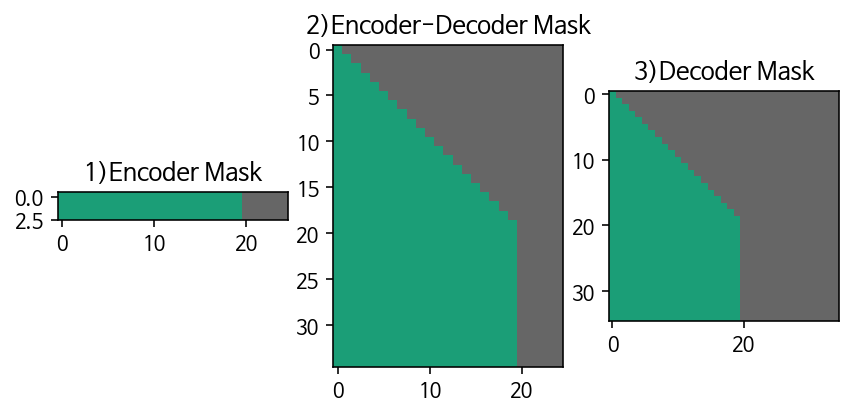

In [333]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1)Encoder Mask')
ax2.set_title('2)Encoder-Decoder Mask')
ax3.set_title('3)Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show

In [334]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    
learning_rate = LearningRateScheduler(512)
oprimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [335]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=len(enc_train),
    tgt_vocab_size=len(dec_train),
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [336]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [337]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [338]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## Training

In [ ]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/tmp/ipykernel_233/4273148178.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

## Evaluation

In [ ]:
def evaluate(sentence, model):
    mecab = Mecab()
    
    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    
    tokens = []
    for sen in pieces:
        sen= get_encoded_sentence(sen, word_to_index)
        tokens.append(sen)
    
    _input = keras.preprocessing.sequence.pad_sequences(tokens,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=20)
    
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)

    return result

In [ ]:
sample_text = ['지루하다, 놀러가고 싶어.',
               '오늘 일찍 일어났더니 피곤하다.',
               '간만에 여자친구랑 데이트 하기로 했어.',
               '집에 있는다는 소리야.']

In [ ]:
for sen in sample_text:
    print('원문 : ', sen)
    print('답변 : ', translate(sen, transformer))

## Discussion

1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?  
 - **챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.**  
 
 
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?  
 - **과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.**  
 
 
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?  
 - **주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.**

## Reference

1. https://iambeginnerdeveloper.tistory.com/41
2. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-12%5Dtransformer_chatbot.ipynb
3. https://github.com/hongdune/aiffel/blob/master/GD12_chatbot.ipynb
4. https://stackoverflow.com/questions/7197315/5-maximum-values-in-a-python-dictionary